In [2]:
import pandas as pd
import glob
import os
import shutil
import re

from plotnine import *
from datetime import datetime

from scipy.spatial import distance
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [5]:
entry_directory = "Raw"
prepared_directory = "Prepared"
organised_directory = "Organised"

In [ ]:
def calculate_sums(file_path):

    node_data_df = pd.read_csv(file_path, dtype = {'timestamp' : 'string', 'PID' : 'int', 'CPU': 'float64', 'RAM': 'float64'})
    node_data_df['timestamp'] = node_data_df['timestamp'].apply(lambda x: x if len(x.split(".")) > 1 else x + ".000000" )
    node_data_df['epoch'] = node_data_df['timestamp'].apply(lambda x: (datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") - datetime(1970, 1, 1)).total_seconds())
    min_timestamp = node_data_df['epoch'].min()
    node_data_df['epoch'] = node_data_df['epoch'].apply(lambda x: x - min_timestamp)
    node_data_df.drop('PID', axis='columns', inplace=True)
    node_data_df.drop('timestamp', axis='columns', inplace=True)
    node_data_df = node_data_df.groupby("epoch").sum()

    return node_data_df


for root, _, files in os.walk(f".\{entry_directory}"):
        for file in files:
            full_path = os.path.join(root, file)
            if re.search("\d\d_\d\d_\d\d\d\d_\d\d_\d\d_\d\d.csv$", full_path):
                if os.path.exists(full_path.replace(entry_directory, prepared_directory)):
                    continue
                calculated_dataframe_to_save = calculate_sums(full_path)
                if not os.path.exists(root.replace(entry_directory, prepared_directory)):
                    os.makedirs(root.replace(entry_directory, prepared_directory))
                calculated_dataframe_to_save.to_csv(full_path.replace(entry_directory, prepared_directory))

KeyboardInterrupt: 

In [ ]:
root = ".\Prepared"
for functionTypeDirectory in os.listdir(root):
    if os.path.isdir(os.path.join(root, functionTypeDirectory)):
        for functionDirectory in os.listdir(os.path.join(root, functionTypeDirectory)):
            for numberOfNodesDirectory in os.listdir(os.path.join(root, functionTypeDirectory, functionDirectory)):
                destinationPath =  os.path.join(root, functionTypeDirectory, functionDirectory, numberOfNodesDirectory, 'source-data')
                for nodeDirectory in os.listdir(destinationPath):
                    path =  os.path.join(destinationPath, nodeDirectory)
                    all_files = glob.glob(path + "/*.csv")
                    dfs = []
                    i = 1
                    for filename in all_files:
                        df = pd.read_csv(filename)
                        dfs.append(df)
                        if df['RAM'].mean() >= 2 and df['CPU'].head(15).mean() > 3:
                            if not os.path.exists(os.path.join(destinationPath.replace("Prepared", "Organised"), str(i))):
                                os.makedirs(os.path.join(destinationPath.replace("Prepared", "Organised"), str(i)))
                            shutil.copyfile(filename, os.path.join(destinationPath.replace("Prepared", "Organised"), str(i), os.path.basename(filename)))
                        i += 1


In [ ]:
def join_files(entry_dir, category):
    directory = f"./{entry_dir}/{category}"
    udf_dirs = os.listdir(directory)
    label = category
    result_df = pd.DataFrame()
    snapshot = 0
    for udf in udf_dirs:
        for root, _, files in os.walk(f"./{directory}/{udf}"):
            for file in files:
                full_path = os.path.join(root, file)
                node_data_df = pd.read_csv(full_path)
                node_data_df['snapshot'] = snapshot
                snapshot += 1
                node_data_df["label"] = label
                node_data_df["udf"] = udf
                result_df = pd.concat([result_df,node_data_df])
    result_df[["snapshot", "label", "udf", "epoch", "CPU", "RAM"]].to_csv(f"{directory}/joined_{category}.csv", index = False)

labels = ['aggregation', 'filtration', 'filtration-aggregation', 'filtration-aggregation-join', 'filtration-join']

for label in labels:
    join_files(organised_directory, label)

In [6]:
def smooth_values(entry_dir, category, window_value,):
    # reading file
    path_to_df = f"./{entry_dir}/{category}/joined_{category}.csv"
    df = pd.read_csv(path_to_df)
    cpu_df = df.groupby('snapshot')['CPU'].rolling(window=window_value, min_periods = 1).mean().to_frame()
    ram_df = df.groupby('snapshot')['RAM'].rolling(window=window_value, min_periods = 1).mean().to_frame()
    df['CPU'] = cpu_df.reset_index()['CPU'] 
    df['CPU'] = df['CPU'].round(2)
    df['RAM'] = ram_df.reset_index()['RAM']
    df['RAM'] = df['RAM'].round(2)
    df['epoch'] = df['epoch'].round(3)
    df.fillna(0).to_csv(f"./{entry_dir}/{category}/{window_value}_smooth_{category}.csv", index = False)

for label in labels:
    smooth_values(organised_directory, label, 6)

NameError: name 'labels' is not defined

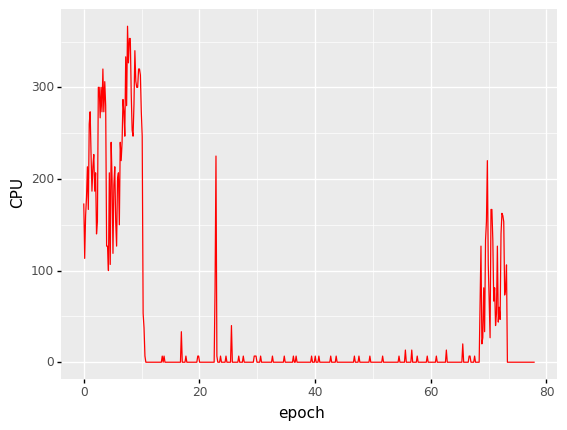

<ggplot: (156046038673)>

In [11]:
%matplotlib inline
joined_aggregation_all = pd.read_csv("Organised/aggregation/joined_aggregation.csv")
joined_aggregation = joined_aggregation_all[joined_aggregation_all["snapshot"] == 1]

(ggplot(joined_aggregation)         # defining what data to use
  + aes(x='epoch', y = "CPU")    # defining what variable to use
  + geom_line(size=0.5, color = "red") # defining the type of plot to use
 )

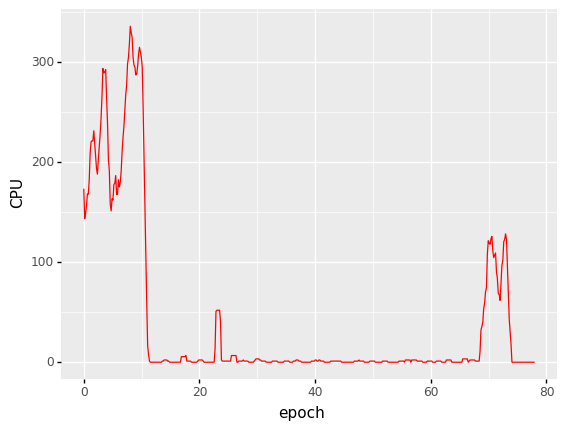

<ggplot: (156054641881)>

In [9]:
joined_aggregation_smooth_all = pd.read_csv("Organised/aggregation/6_smooth_aggregation.csv")
joined_aggregation_smooth = joined_aggregation_smooth_all[joined_aggregation_smooth_all["snapshot"] == 1]

(ggplot(joined_aggregation_smooth)         # defining what data to use
 + aes(x='epoch', y = "CPU")    # defining what variable to use
 + geom_line(size=0.5, color = "red") # defining the type of plot to use
)

In [18]:
def calculate_euclidean_distance(data, snapshot1, snapshot2, max_length):
    a = data[data["snapshot"] == snapshot1].head(max_length)
    b = data[data["snapshot"] == snapshot2].head(max_length)
    cpu_dst = distance.euclidean(a['CPU'], b['CPU'])
    ram_dst = distance.euclidean(a['RAM'], b['RAM'])
    return cpu_dst, ram_dst

def calculate_dtw(data, snapshot1, snapshot2, data2=pd.DataFrame()):
    if data2.empty:
        data2 = data
    a = data[data["snapshot"] == snapshot1]
    b = data2[data2["snapshot"] == snapshot2]
    alignment_cpu = dtw(a['CPU'], b['CPU'], keep_internals=True)
    alignment_ram = dtw(a['RAM'], b['RAM'], keep_internals=True)
    return alignment_cpu.normalizedDistance, alignment_cpu.distance, alignment_ram.normalizedDistance, alignment_ram.distance

def draw_comparison_diagram(data, snapshot1, snapshot2, title="Title", y_data = "CPU", data2=pd.DataFrame(), max_length=496):
    if data2.empty:
        data2 = data
    a = data[data["snapshot"] == snapshot1]
    b = data2[data2["snapshot"] == snapshot2]
    comparison_data = pd.concat([a, b])
    euc_cpu_dist, euc_ram_dist = calculate_euclidean_distance(comparison_data, snapshot1, snapshot2, max_length)
    dtw_cpu_dist_normalized, dtw_cpu_dist, dtw_ram_dist_normalized, dtw_ram_dist = \
        calculate_dtw(a, snapshot1, snapshot2, b)
    if y_data == "CPU":
        euc_dist = euc_cpu_dist
        dtw_dist_normalized = dtw_cpu_dist_normalized
        dtw_dist = dtw_cpu_dist
    else:
        euc_dist = euc_ram_dist
        dtw_dist_normalized = dtw_ram_dist_normalized
        dtw_dist = dtw_ram_dist
    return qplot(data=comparison_data, x="epoch", y=y_data,
          facets="snapshot",
          color = "factor(snapshot)",
          geom="line",
          xlab="Epoch", ylab=y_data,
          main=title
               + "\nEuclidan distance:"+ str(round(euc_dist, 2))
               + "\nDTW normalized distance:"+ str(round(dtw_dist_normalized, 2))
               + "\nDTW distance:"+ str(round(dtw_dist, 2))) \
    + \
    theme(figure_size=(11,6))

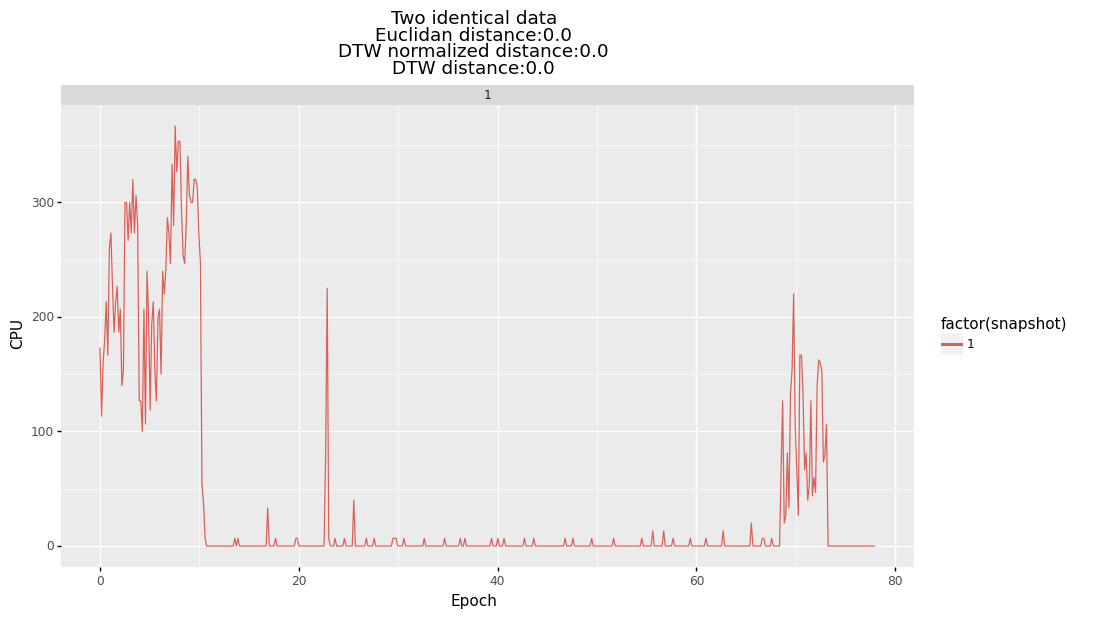

In [17]:
print(draw_comparison_diagram(joined_aggregation_all, 1, 1, "Two identical data"))

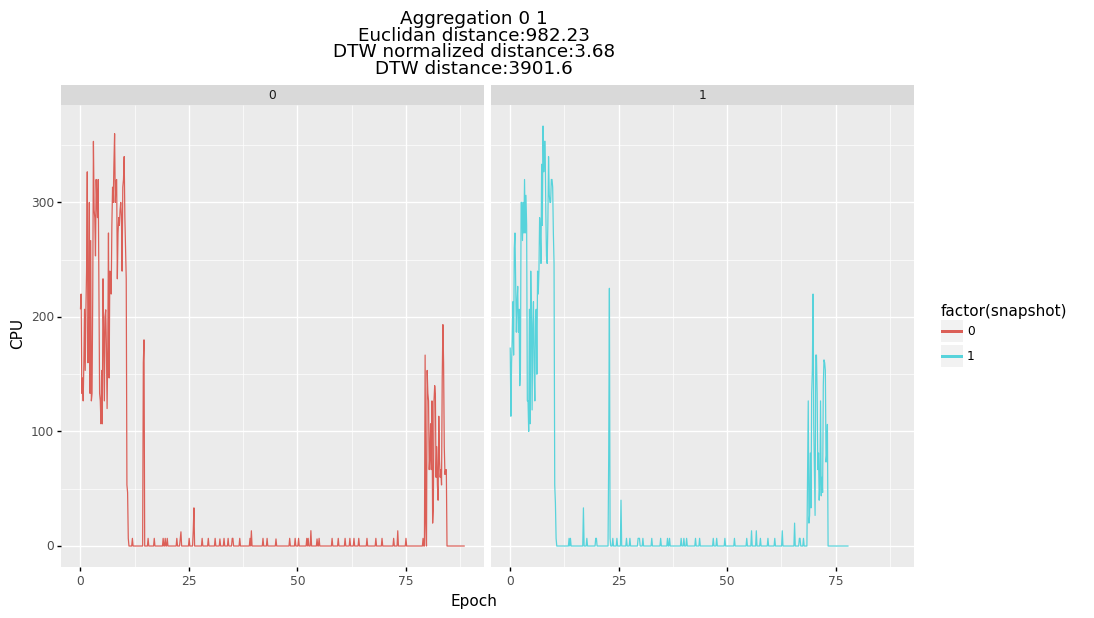

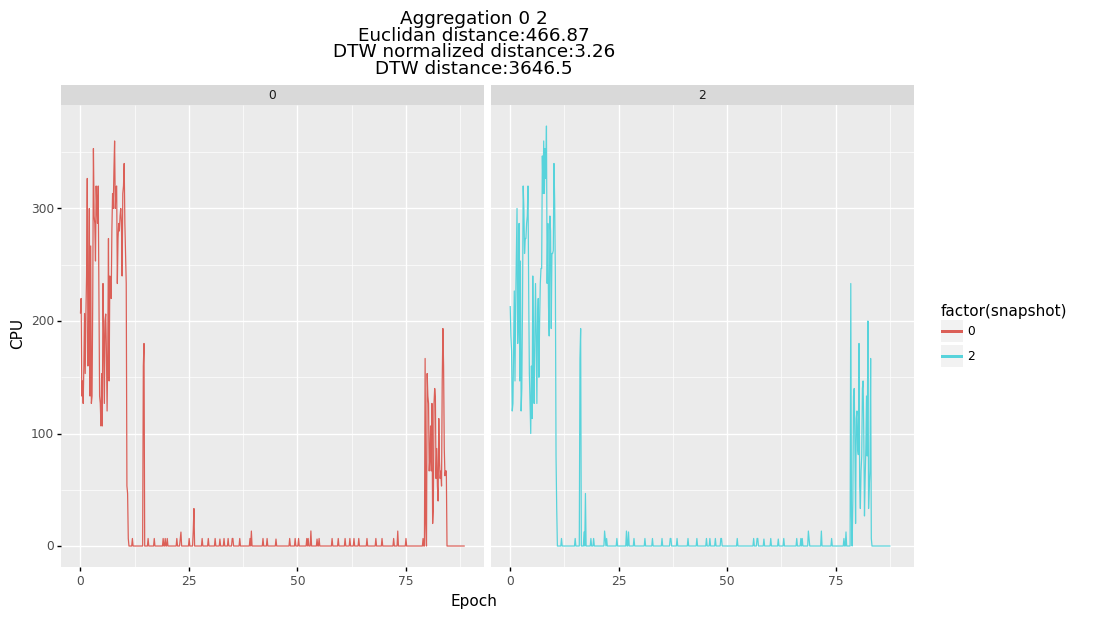

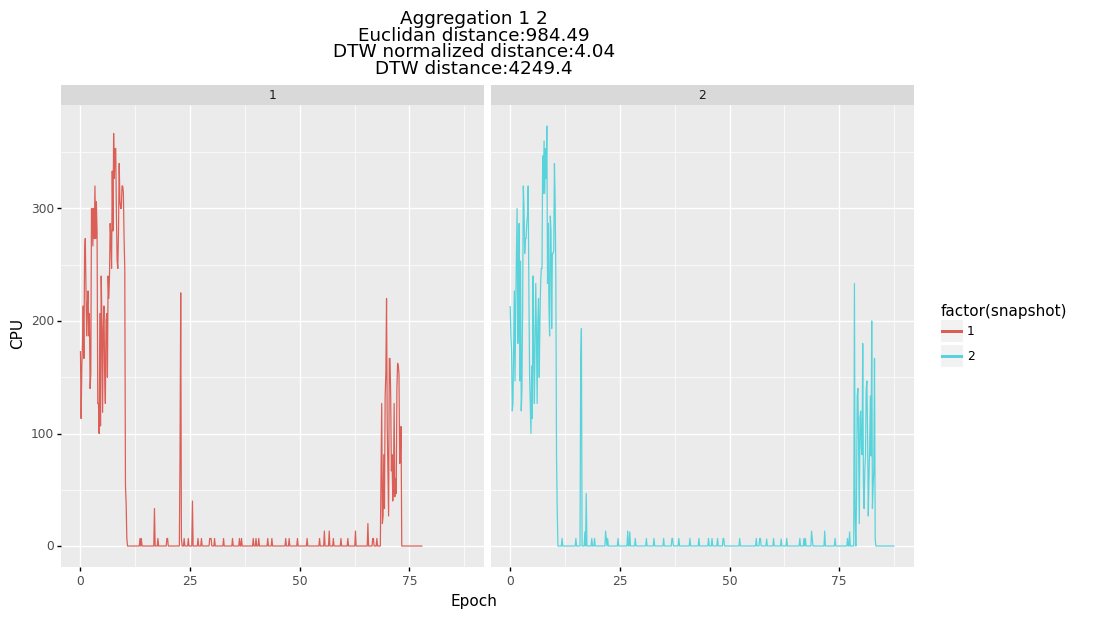

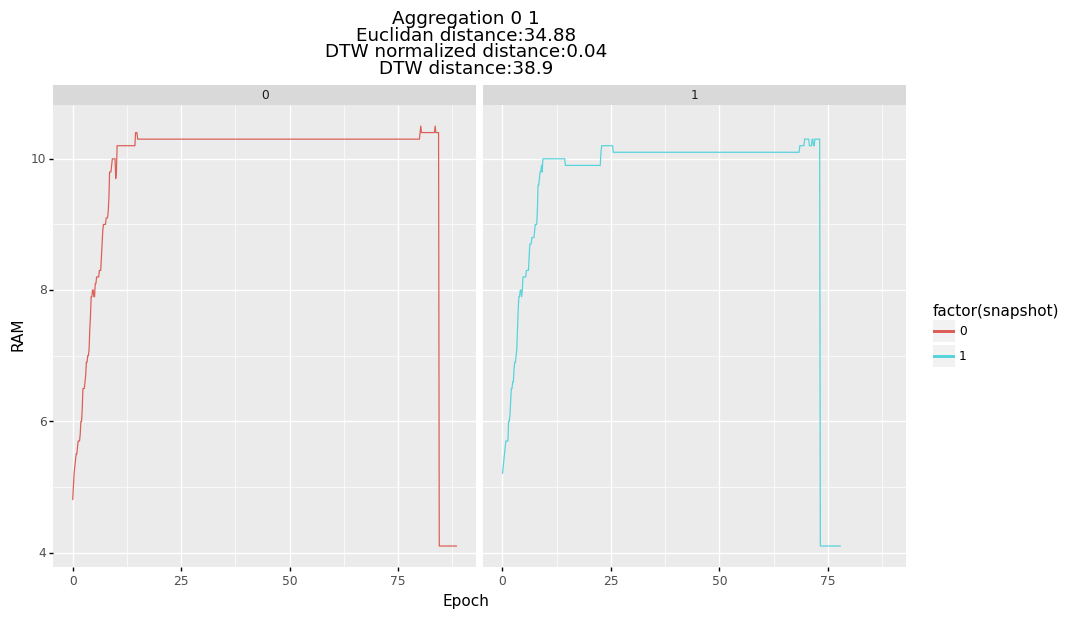

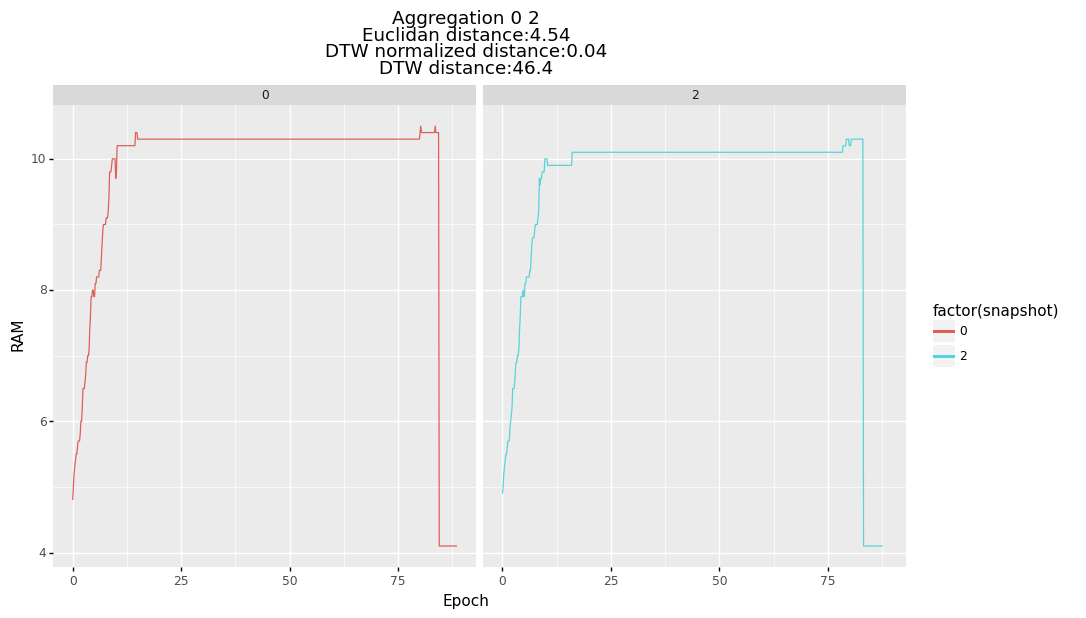

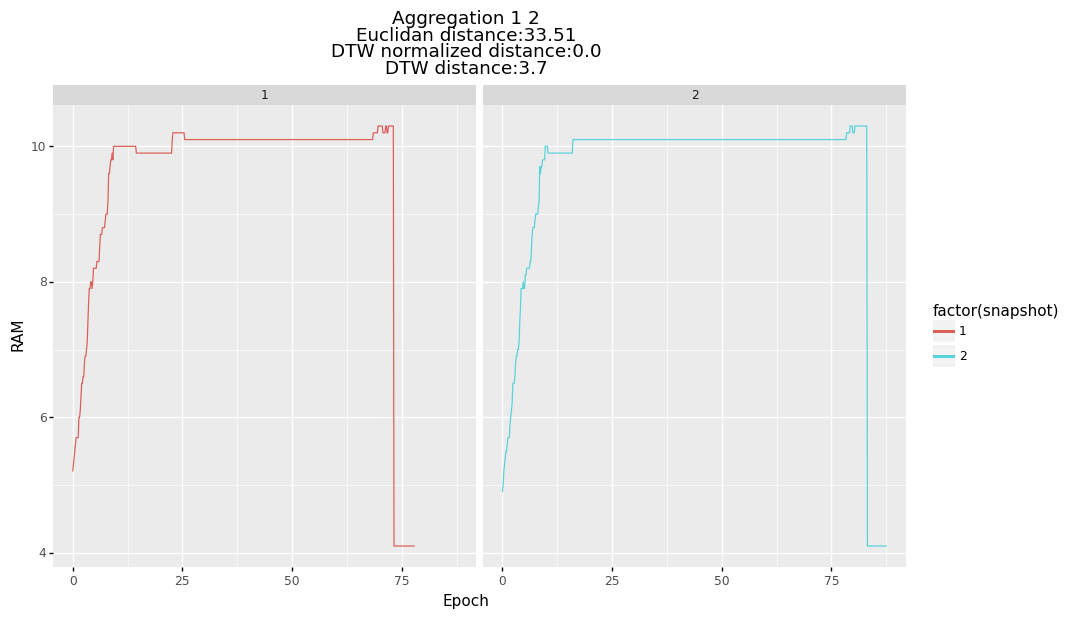

In [19]:
## CPU
print(draw_comparison_diagram(joined_aggregation_all, 0, 1, "Aggregation 0 1"))
print(draw_comparison_diagram(joined_aggregation_all, 0, 2, "Aggregation 0 2"))
print(draw_comparison_diagram(joined_aggregation_all, 1, 2, "Aggregation 1 2"))
## RAM
print(draw_comparison_diagram(joined_aggregation_all, 0, 1, "Aggregation 0 1", "RAM"))
print(draw_comparison_diagram(joined_aggregation_all, 0, 2, "Aggregation 0 2", "RAM"))
print(draw_comparison_diagram(joined_aggregation_all, 1, 2, "Aggregation 1 2", "RAM"))

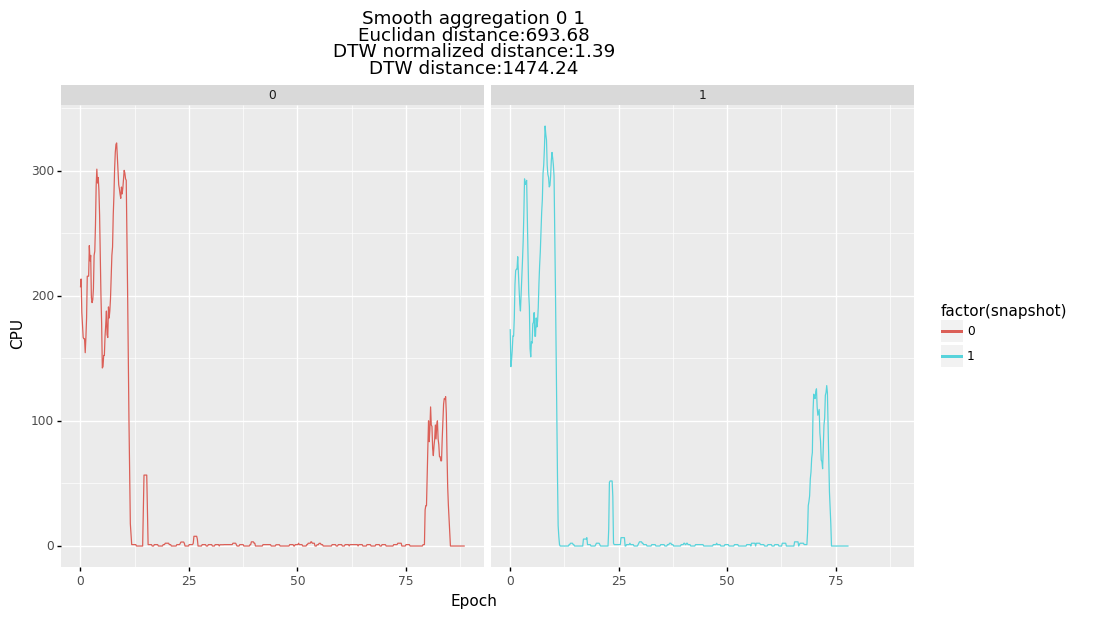

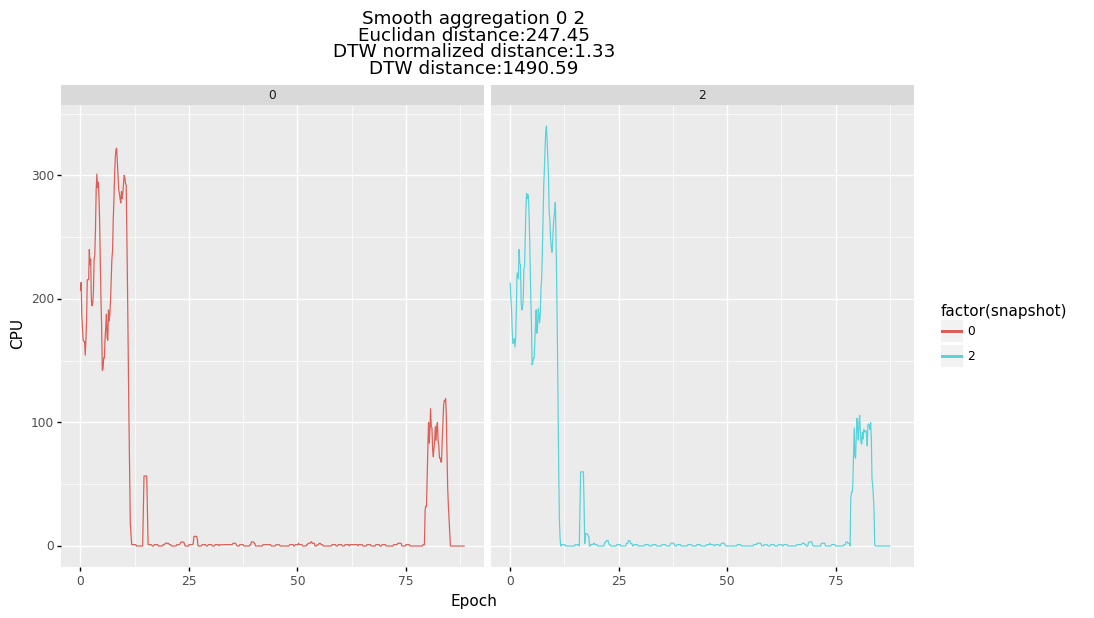

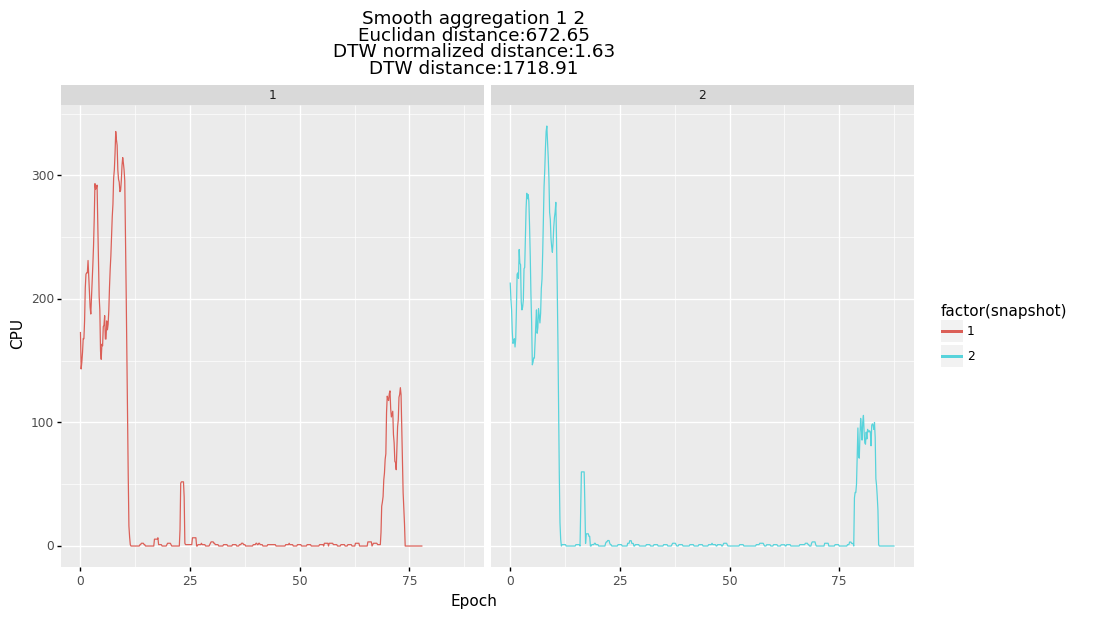

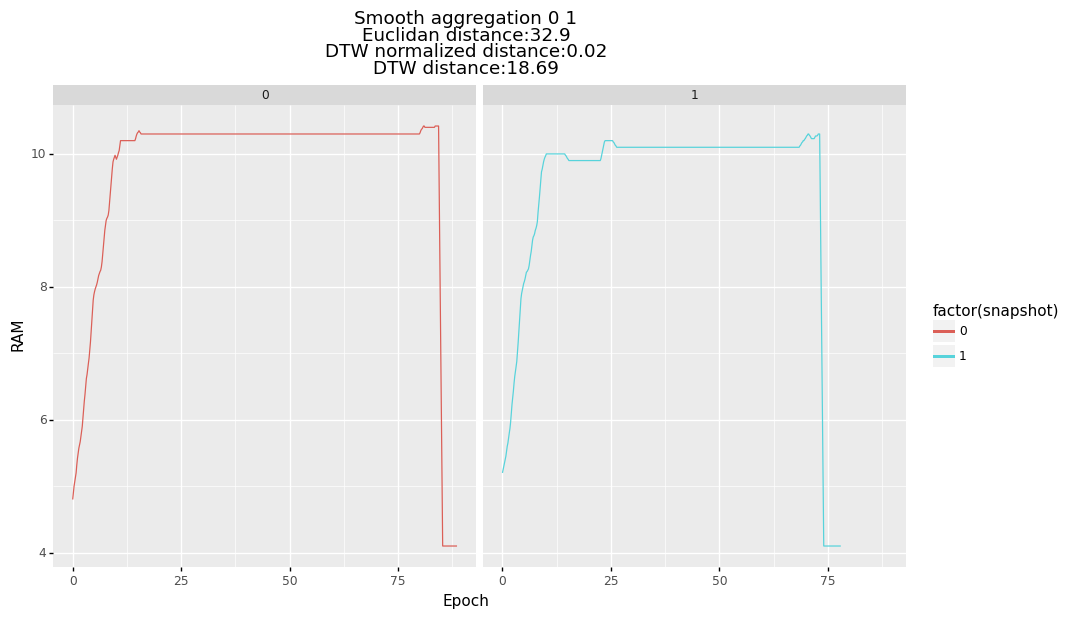

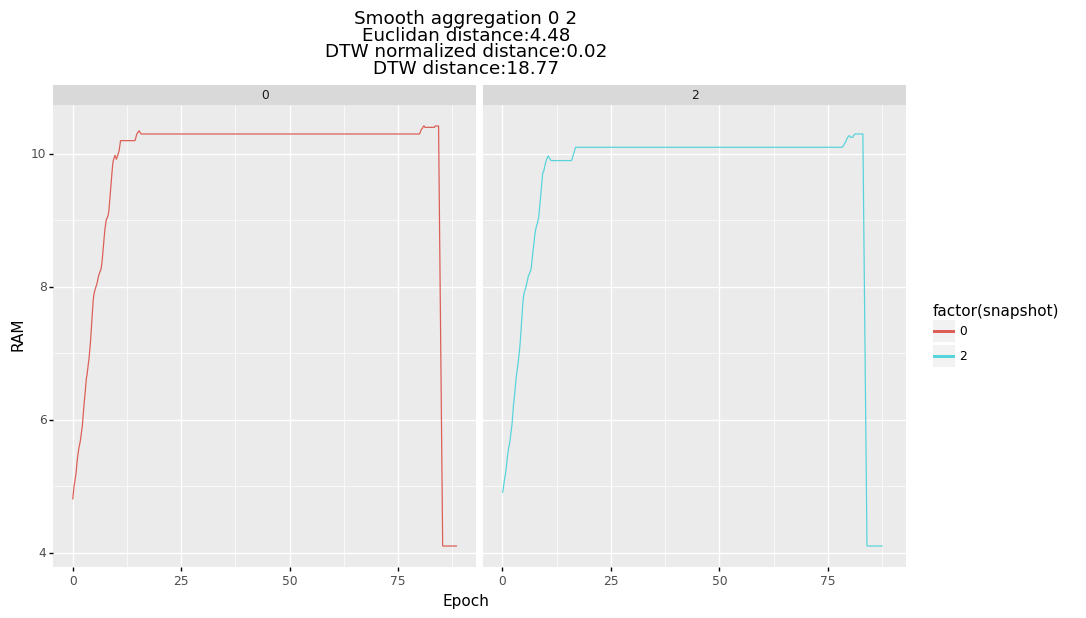

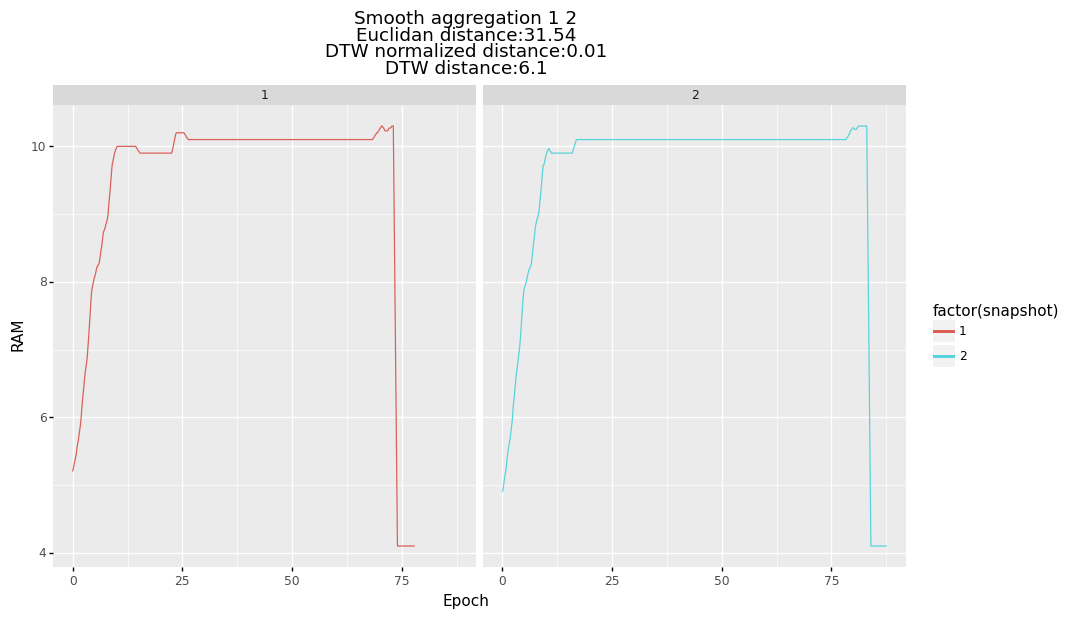

In [20]:
## CPU
print(draw_comparison_diagram(joined_aggregation_smooth_all, 0, 1, "Smooth aggregation 0 1"))
print(draw_comparison_diagram(joined_aggregation_smooth_all, 0, 2, "Smooth aggregation 0 2"))
print(draw_comparison_diagram(joined_aggregation_smooth_all, 1, 2, "Smooth aggregation 1 2"))
## RAM
print(draw_comparison_diagram(joined_aggregation_smooth_all, 0, 1, "Smooth aggregation 0 1", "RAM"))
print(draw_comparison_diagram(joined_aggregation_smooth_all, 0, 2, "Smooth aggregation 0 2", "RAM"))
print(draw_comparison_diagram(joined_aggregation_smooth_all, 1, 2, "Smooth aggregation 1 2", "RAM"))

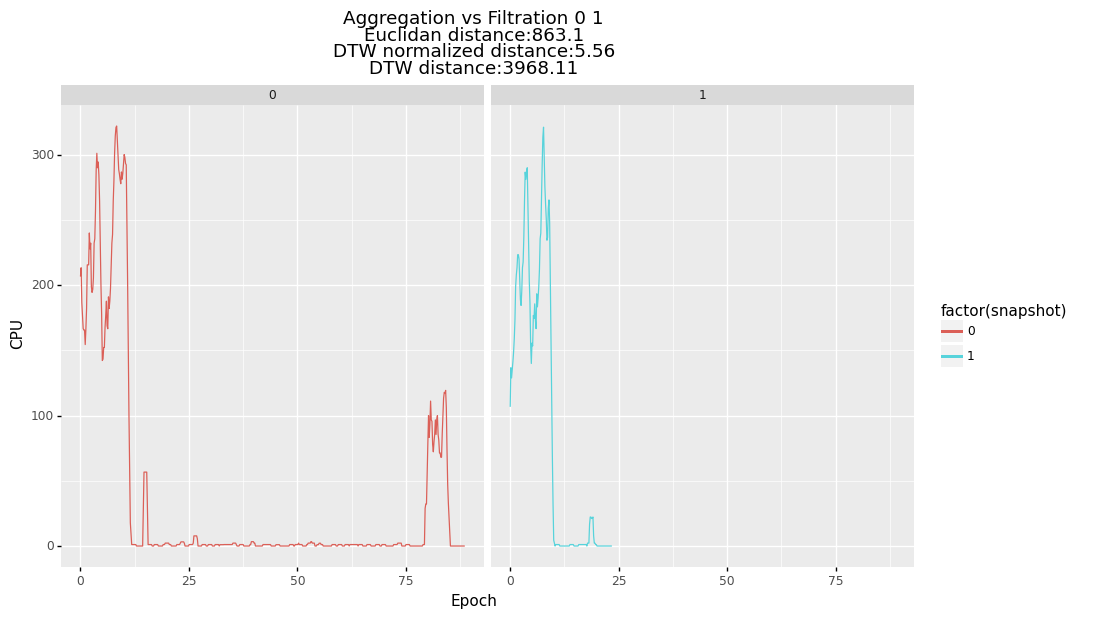

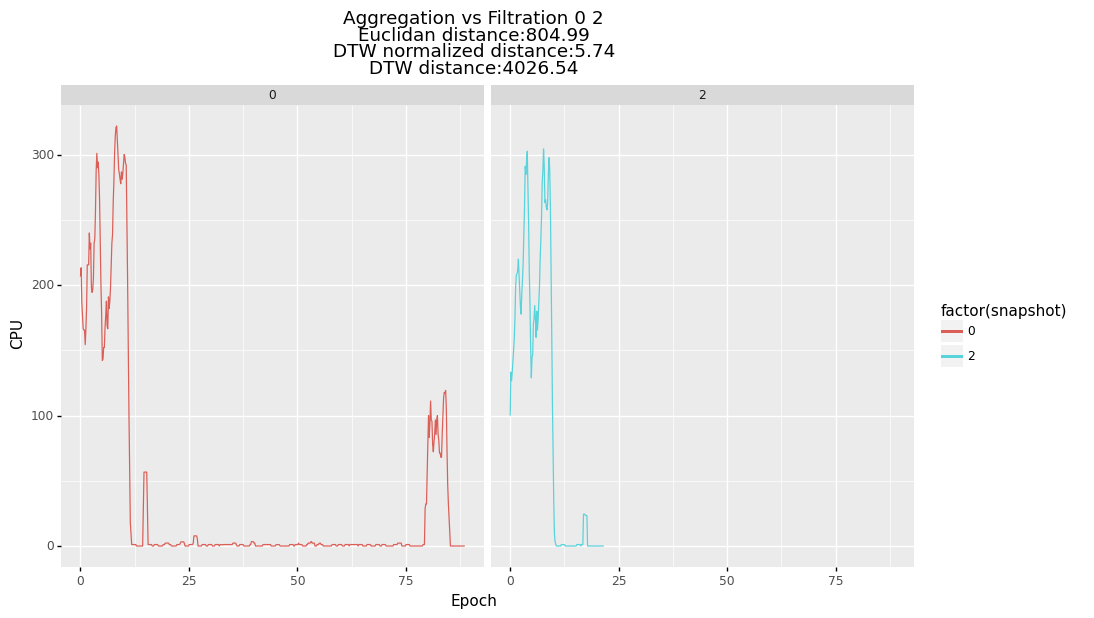

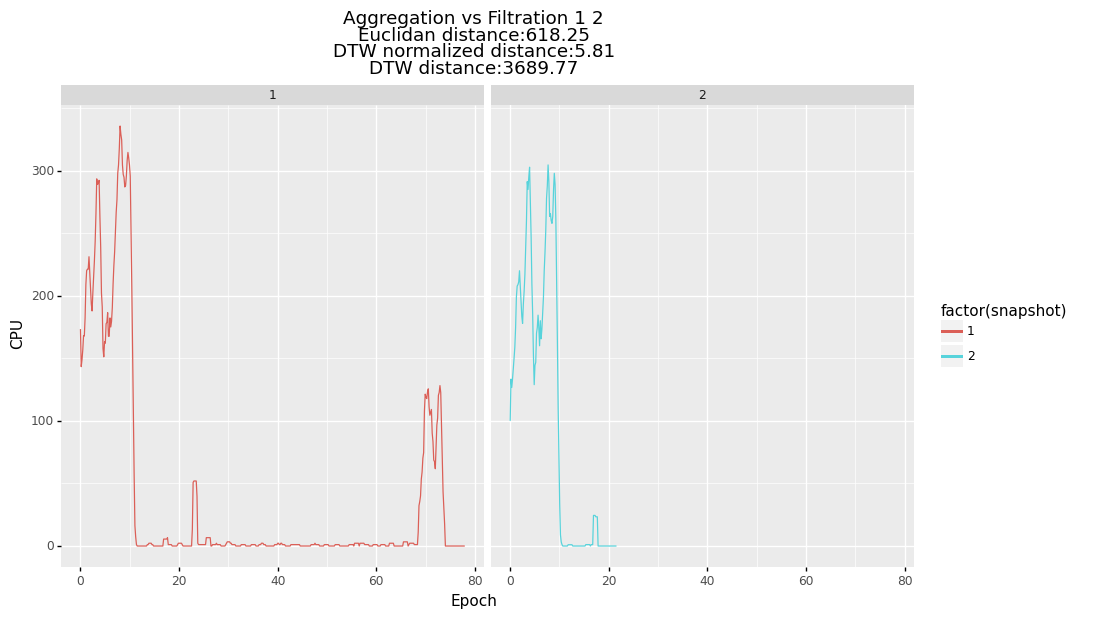

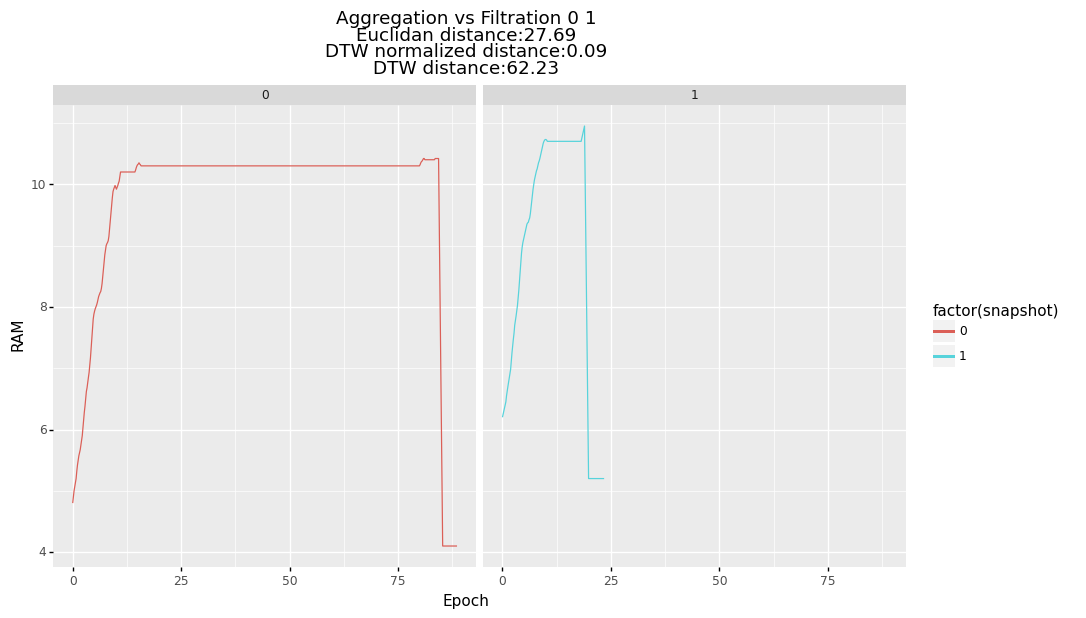

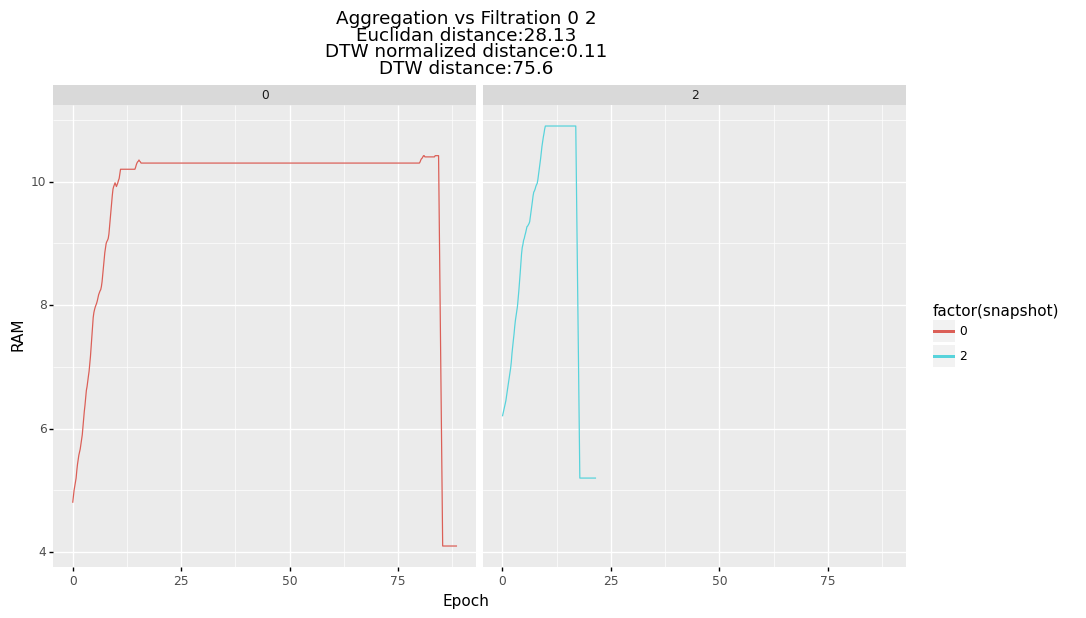

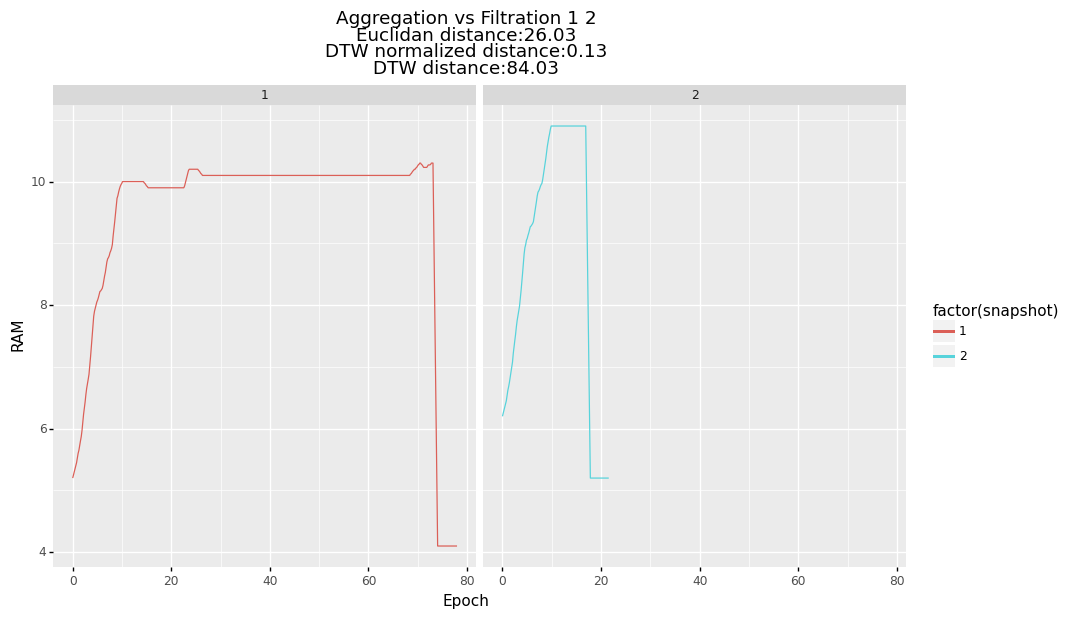

In [21]:
# Compare two different functions
joined_filtration_all = pd.read_csv("Organised/filtration/6_smooth_filtration.csv")
## CPU
print(draw_comparison_diagram(joined_aggregation_smooth_all, 0, 1,  "Aggregation vs Filtration 0 1", "CPU", joined_filtration_all, 151))
print(draw_comparison_diagram(joined_aggregation_smooth_all, 0, 2,  "Aggregation vs Filtration 0 2", "CPU", joined_filtration_all, 139))
print(draw_comparison_diagram(joined_aggregation_smooth_all, 1, 2,  "Aggregation vs Filtration 1 2", "CPU", joined_filtration_all, 139))

## RAM
print(draw_comparison_diagram(joined_aggregation_smooth_all, 0, 1,  "Aggregation vs Filtration 0 1", "RAM", joined_filtration_all, 151))
print(draw_comparison_diagram(joined_aggregation_smooth_all, 0, 2,  "Aggregation vs Filtration 0 2", "RAM", joined_filtration_all, 139))
print(draw_comparison_diagram(joined_aggregation_smooth_all, 1, 2,  "Aggregation vs Filtration 1 2", "RAM", joined_filtration_all, 139))

In [15]:
help(DTW)

Help on class DTW in module dtw.dtw:

class DTW(builtins.object)
 |  DTW(obj)
 |  
 |  The results of an alignment operation.
 |  
 |  Objects of class DTW contain alignments computed by the [dtw()]
 |  function. 
 |  
 |  **Attributes:**
 |  
 |  - ``distance`` the minimum global distance computed, *not* normalized.
 |  - ``normalizedDistance`` distance computed, *normalized* for path
 |    length, if normalization is known for chosen step pattern.
 |  - ``N,M`` query and reference length
 |  - ``call`` the function call that created the object
 |  - ``index1`` matched elements: indices in ``x``
 |  - ``index2`` corresponding mapped indices in ``y``
 |  - ``stepPattern`` the ``stepPattern`` object used for the computation
 |  - ``jmin`` last element of reference matched, if ``open_end=True``
 |  - ``directionMatrix`` if ``keep_internals=True``, the directions of
 |    steps that would be taken at each alignment pair (integers indexing
 |    production rules in the chosen step pattern)